In [163]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [164]:
pd.options.display.max_columns = False
df = pd.read_csv('../data/lovoo_v3_users_api-results/lovoo_v3_users_api-results.csv')

## Data Inspection

In [165]:
df.head()

,gender,genderLooking,age,name,counts_details,counts_pictures,counts_profileVisits,counts_kisses,counts_fans,counts_g,flirtInterests_chat,flirtInterests_friends,flirtInterests_date,country,city,location,distance,isFlirtstar,isHighlighted,isInfluencer,isMobile,isNew,isOnline,isVip,lang_count,lang_fr,lang_en,lang_de,lang_it,lang_es,lang_pt,verified,shareProfileEnabled,lastOnlineDate,lastOnlineTime,birthd,crypt,freetext,whazzup,userId,pictureId,isSystemProfile
0,F,M,25,daeni,1.00,4,8279,239,0,3,True,True,True,CH,Rothenburg,Rümlang,175.0,0,0,0,1,0,0,0,1,False,False,True,False,False,False,0,1,2015-04-25T20:43:26Z,1.429995e+09,0,NaN,Nur tote Fisch schwimmen mit dem Strom,Nur tote fische schwimmen mit dem strom,4e3842f79b70e7ea57000064,55303fc3160ba0eb728b4575,NaN
1,F,M,22,italiana 92,0.85,5,663,13,0,0,True,True,True,CH,Sissach,Sissach,138.0,0,0,0,1,0,0,0,3,True,False,True,True,False,False,0,1,2015-04-26T09:19:35Z,1.430040e+09,0,NaN,NaN,Primaveraaa<3,4e3d34bf5d2bce7b160006a3,552e7b61c66da10d1e8b4c82,NaN
2,F,M,21,Lauraaa,0.00,4,1369,88,0,2,False,False,True,CH,Bâle,Bâle,137.0,0,0,0,0,0,1,0,0,False,False,False,False,False,False,0,1,2015-04-06T14:24:07Z,1.428330e+09,0,NaN,NaN,NaN,4ec96c090dc82cb25d00000a,54a584ecc56da128638b4674,NaN
3,F,none,20,Qqkwmdowlo,0.12,3,22187,1015,2,3,True,True,False,CA,Montréal,Berne,77.3,0,0,0,0,0,0,0,2,True,True,False,False,False,False,0,1,2015-04-07T11:21:01Z,1.428406e+09,0,NaN,NaN,Je pense donc je suis. Instagram quedev,4eef8b81ebf2c8f64000000c,54c92738076ea1b5338b4735,NaN
4,F,M,21,schaessie {3,0.15,12,35262,1413,9,12,True,False,False,DE,Rastatt,Rastatt,286.0,0,0,0,0,0,1,0,1,False,False,True,False,False,False,0,1,2015-04-06T14:25:20Z,1.428330e+09,0,NaN,NaN,Instagram: JESSSIESCH,4ef3cc5aa9d0b3d07d000017,54e1a6f6c76da135748b4a3a,NaN


In [166]:
df.duplicated().sum()

np.int64(0)

In [167]:
df.shape

(3992, 42)

In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3992 entries, 0 to 3991
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  3992 non-null   object 
 1   genderLooking           3992 non-null   object 
 2   age                     3992 non-null   int64  
 3   name                    3992 non-null   object 
 4   counts_details          3992 non-null   float64
 5   counts_pictures         3992 non-null   int64  
 6   counts_profileVisits    3992 non-null   int64  
 7   counts_kisses           3992 non-null   int64  
 8   counts_fans             3992 non-null   int64  
 9   counts_g                3992 non-null   int64  
 10  flirtInterests_chat     3992 non-null   bool   
 11  flirtInterests_friends  3992 non-null   bool   
 12  flirtInterests_date     3992 non-null   bool   
 13  country                 3992 non-null   object 
 14  city                    3705 non-null   

I want to make sure that every feature in the dataset is usable.
So the first step is to access the full list of column names:

In [169]:
df.columns

Index(['gender', 'genderLooking', 'age', 'name', 'counts_details',
       'counts_pictures', 'counts_profileVisits', 'counts_kisses',
       'counts_fans', 'counts_g', 'flirtInterests_chat',
       'flirtInterests_friends', 'flirtInterests_date', 'country', 'city',
       'location', 'distance', 'isFlirtstar', 'isHighlighted', 'isInfluencer',
       'isMobile', 'isNew', 'isOnline', 'isVip', 'lang_count', 'lang_fr',
       'lang_en', 'lang_de', 'lang_it', 'lang_es', 'lang_pt', 'verified',
       'shareProfileEnabled', 'lastOnlineDate', 'lastOnlineTime', 'birthd',
       'crypt', 'freetext', 'whazzup', 'userId', 'pictureId',
       'isSystemProfile'],
      dtype='object')

Let's evaluate next columns: `isFlirtstar`, `isHighlighted`, `isInfluencer`. 
These columns appear to contain only zeros, which means they might not carry any useful information for the analysis.

Let’s confirm by checking how many non-zero or non-null values exist:

In [170]:
print('isFlirtstar:', (df['isFlirtstar'] != 0).sum())
print('isHighlighted:', (df['isHighlighted'] != 0).sum())
print('isInfluencer:', (df['isInfluencer'] != 0).sum())

isFlirtstar: 47
isHighlighted: 47
isInfluencer: 0


Column `isInfluencer` contains only zeros, so it doesn’t provide any useful information and will be dropped. 

Columns `isFlirtstar`, `isHighlighted` have 47 non-zero values but I could not find any information what this columns mean so I'm gonna drop it too.

Column `birthd` doesn't contain an actual date. Let's prove it.

In [171]:
df.birthd.value_counts()

birthd
0    3977
1      15
Name: count, dtype: int64

I decided to drop a few columns that don’t contain useful information for EDA.
This includes the columns discussed earlier, as well as a few others that are clearly irrelevant for an analysis.

In [172]:
df = df.drop(
    columns=['distance', 
             'isFlirtstar', 
             'isHighlighted', 
             'isInfluencer',
             'isMobile', 
             'isNew', 
             'isOnline', 
             'lang_fr',
             'lang_en', 
             'lang_de', 
             'lang_it', 
             'lang_es', 
             'lang_pt', 
             'lastOnlineDate', 
             'lastOnlineTime', 
             'birthd',
             'crypt', 
             'userId', 
             'pictureId',
             'isSystemProfile']
             )

In [173]:
df.duplicated().sum()

np.int64(20)

In [174]:
df = df.drop_duplicates()

In [175]:
df.isna().sum()

gender                       0
genderLooking                0
age                          0
name                         0
counts_details               0
counts_pictures              0
counts_profileVisits         0
counts_kisses                0
counts_fans                  0
counts_g                     0
flirtInterests_chat          0
flirtInterests_friends       0
flirtInterests_date          0
country                      0
city                       287
location                    13
isVip                        0
lang_count                   0
verified                     0
shareProfileEnabled          0
freetext                  3859
whazzup                   1580
dtype: int64

In [176]:
df.head()

,gender,genderLooking,age,name,counts_details,counts_pictures,counts_profileVisits,counts_kisses,counts_fans,counts_g,flirtInterests_chat,flirtInterests_friends,flirtInterests_date,country,city,location,isVip,lang_count,verified,shareProfileEnabled,freetext,whazzup
0,F,M,25,daeni,1.00,4,8279,239,0,3,True,True,True,CH,Rothenburg,Rümlang,0,1,0,1,Nur tote Fisch schwimmen mit dem Strom,Nur tote fische schwimmen mit dem strom
1,F,M,22,italiana 92,0.85,5,663,13,0,0,True,True,True,CH,Sissach,Sissach,0,3,0,1,NaN,Primaveraaa<3
2,F,M,21,Lauraaa,0.00,4,1369,88,0,2,False,False,True,CH,Bâle,Bâle,0,0,0,1,NaN,NaN
3,F,none,20,Qqkwmdowlo,0.12,3,22187,1015,2,3,True,True,False,CA,Montréal,Berne,0,2,0,1,NaN,Je pense donc je suis. Instagram quedev
4,F,M,21,schaessie {3,0.15,12,35262,1413,9,12,True,False,False,DE,Rastatt,Rastatt,0,1,0,1,NaN,Instagram: JESSSIESCH


The last thing I want to do before starting the EDA is to fix the lang_count column.

Some rows contain a value of 0, which doesn’t make sense — users must have at least one language. Most likely, lang_count only reflects languages among this specific set: French, English, German, Italian, Spanish, and Portuguese.

I’ll treat 0 values in the lang_count column as 1, assuming each user must speak at least one language.


In [177]:
df['lang_count'] = df['lang_count'].replace(0, 1)

In [178]:
df.head()

,gender,genderLooking,age,name,counts_details,counts_pictures,counts_profileVisits,counts_kisses,counts_fans,counts_g,flirtInterests_chat,flirtInterests_friends,flirtInterests_date,country,city,location,isVip,lang_count,verified,shareProfileEnabled,freetext,whazzup
0,F,M,25,daeni,1.00,4,8279,239,0,3,True,True,True,CH,Rothenburg,Rümlang,0,1,0,1,Nur tote Fisch schwimmen mit dem Strom,Nur tote fische schwimmen mit dem strom
1,F,M,22,italiana 92,0.85,5,663,13,0,0,True,True,True,CH,Sissach,Sissach,0,3,0,1,NaN,Primaveraaa<3
2,F,M,21,Lauraaa,0.00,4,1369,88,0,2,False,False,True,CH,Bâle,Bâle,0,1,0,1,NaN,NaN
3,F,none,20,Qqkwmdowlo,0.12,3,22187,1015,2,3,True,True,False,CA,Montréal,Berne,0,2,0,1,NaN,Je pense donc je suis. Instagram quedev
4,F,M,21,schaessie {3,0.15,12,35262,1413,9,12,True,False,False,DE,Rastatt,Rastatt,0,1,0,1,NaN,Instagram: JESSSIESCH


## EDA

I’ll focus on two groups of users in the dataset:

- Users who are **interested in dating** (`flirtInterests_date = True`)
- Users who are **not interested in dating** (`flirtInterests_date = False`)

The goal is to explore how their behavior differs across various profile and activity features.

In [179]:
# users interested in dating
dating_users = df[df['flirtInterests_date'] == True]

In [180]:
dating_users.describe()

,age,counts_details,counts_pictures,counts_profileVisits,counts_kisses,counts_fans,counts_g,isVip,lang_count,verified,shareProfileEnabled
count,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000
mean,22.136541,0.603901,4.853706,4110.331599,172.524707,2.356307,0.177503,0.022757,1.142393,0.250975,0.951235
std,1.969403,0.319751,4.397912,8117.828462,435.896773,12.669790,1.428527,0.149176,0.561052,0.433715,0.215446
min,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,21.000000,0.380000,2.000000,390.000000,11.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
50%,22.000000,0.690000,4.000000,1286.000000,46.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,24.000000,0.880000,6.000000,4412.500000,150.750000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,26.000000,1.000000,30.000000,164425.000000,9288.000000,241.000000,39.000000,1.000000,7.000000,1.000000,1.000000


In [181]:
dating_users.corr(numeric_only=True)

,age,counts_details,counts_pictures,counts_profileVisits,counts_kisses,counts_fans,counts_g,flirtInterests_chat,flirtInterests_friends,flirtInterests_date,isVip,lang_count,verified,shareProfileEnabled
age,1.000000,-0.054273,-0.117205,-0.063785,-0.049284,-0.015484,0.000861,-0.011012,0.025291,NaN,-0.019442,-0.012897,-0.121648,-0.036433
counts_details,-0.054273,1.000000,0.356108,0.156435,0.118520,0.065490,0.083105,0.095361,0.030739,NaN,0.089253,0.106681,0.241442,-0.033031
counts_pictures,-0.117205,0.356108,1.000000,0.432176,0.387282,0.147382,0.157612,0.040533,0.013324,NaN,0.065572,0.075686,0.275423,0.021992
counts_profileVisits,-0.063785,0.156435,0.432176,1.000000,0.928297,0.163151,0.612236,0.063616,-0.017093,NaN,0.001166,0.144666,0.194627,-0.069094
counts_kisses,-0.049284,0.118520,0.387282,0.928297,1.000000,0.155869,0.619183,0.047452,-0.026408,NaN,0.008261,0.139608,0.149466,-0.056259
counts_fans,-0.015484,0.065490,0.147382,0.163151,0.155869,1.000000,0.061281,0.014484,-0.019955,NaN,-0.001883,0.031117,0.060321,-0.060607
counts_g,0.000861,0.083105,0.157612,0.612236,0.619183,0.061281,1.000000,0.010005,-0.048876,NaN,-0.018968,0.118622,0.068765,-0.045846
flirtInterests_chat,-0.011012,0.095361,0.040533,0.063616,0.047452,0.014484,0.010005,1.000000,0.584385,NaN,-0.019402,0.086017,0.083604,-0.002725
flirtInterests_friends,0.025291,0.030739,0.013324,-0.017093,-0.026408,-0.019955,-0.048876,0.584385,1.000000,NaN,-0.015623,0.035112,0.067808,0.020160
flirtInterests_date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [182]:
# users not interested in dating
non_dating_users = df[df['flirtInterests_date'] == False]

In [183]:
non_dating_users.describe()

,age,counts_details,counts_pictures,counts_profileVisits,counts_kisses,counts_fans,counts_g,isVip,lang_count,verified,shareProfileEnabled
count,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000
mean,21.905505,0.546039,4.744043,3455.315119,147.024651,2.338127,0.093673,0.023007,1.131060,0.202136,0.967543
std,1.950925,0.327964,4.435478,5913.035295,336.873258,12.005799,1.107209,0.149958,0.550452,0.401676,0.177246
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,20.000000,0.270000,2.000000,382.000000,11.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
50%,22.000000,0.620000,4.000000,1188.500000,42.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,23.000000,0.850000,6.000000,3864.000000,137.750000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,28.000000,1.000000,30.000000,54332.000000,6155.000000,237.000000,43.000000,1.000000,9.000000,1.000000,1.000000


In [184]:
dating_users.corr(numeric_only=True)

,age,counts_details,counts_pictures,counts_profileVisits,counts_kisses,counts_fans,counts_g,flirtInterests_chat,flirtInterests_friends,flirtInterests_date,isVip,lang_count,verified,shareProfileEnabled
age,1.000000,-0.054273,-0.117205,-0.063785,-0.049284,-0.015484,0.000861,-0.011012,0.025291,NaN,-0.019442,-0.012897,-0.121648,-0.036433
counts_details,-0.054273,1.000000,0.356108,0.156435,0.118520,0.065490,0.083105,0.095361,0.030739,NaN,0.089253,0.106681,0.241442,-0.033031
counts_pictures,-0.117205,0.356108,1.000000,0.432176,0.387282,0.147382,0.157612,0.040533,0.013324,NaN,0.065572,0.075686,0.275423,0.021992
counts_profileVisits,-0.063785,0.156435,0.432176,1.000000,0.928297,0.163151,0.612236,0.063616,-0.017093,NaN,0.001166,0.144666,0.194627,-0.069094
counts_kisses,-0.049284,0.118520,0.387282,0.928297,1.000000,0.155869,0.619183,0.047452,-0.026408,NaN,0.008261,0.139608,0.149466,-0.056259
counts_fans,-0.015484,0.065490,0.147382,0.163151,0.155869,1.000000,0.061281,0.014484,-0.019955,NaN,-0.001883,0.031117,0.060321,-0.060607
counts_g,0.000861,0.083105,0.157612,0.612236,0.619183,0.061281,1.000000,0.010005,-0.048876,NaN,-0.018968,0.118622,0.068765,-0.045846
flirtInterests_chat,-0.011012,0.095361,0.040533,0.063616,0.047452,0.014484,0.010005,1.000000,0.584385,NaN,-0.019402,0.086017,0.083604,-0.002725
flirtInterests_friends,0.025291,0.030739,0.013324,-0.017093,-0.026408,-0.019955,-0.048876,0.584385,1.000000,NaN,-0.015623,0.035112,0.067808,0.020160
flirtInterests_date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1. Basic Counts and Percentages

- How many users are interested in dating vs. not?
- What % of the total dataset does each group represent?

In [185]:
dating_counts = df['flirtInterests_date'].value_counts()
total = dating_counts.sum()

interested_count = dating_counts.get(True, 0)
not_interested_count = dating_counts.get(False, 0)

print(f"Interested in Dating: {interested_count} ({interested_count / total:.1%})")
print(f"Not Interested in Dating: {not_interested_count} ({not_interested_count / total:.1%})")

Interested in Dating: 1538 (38.7%)
Not Interested in Dating: 2434 (61.3%)


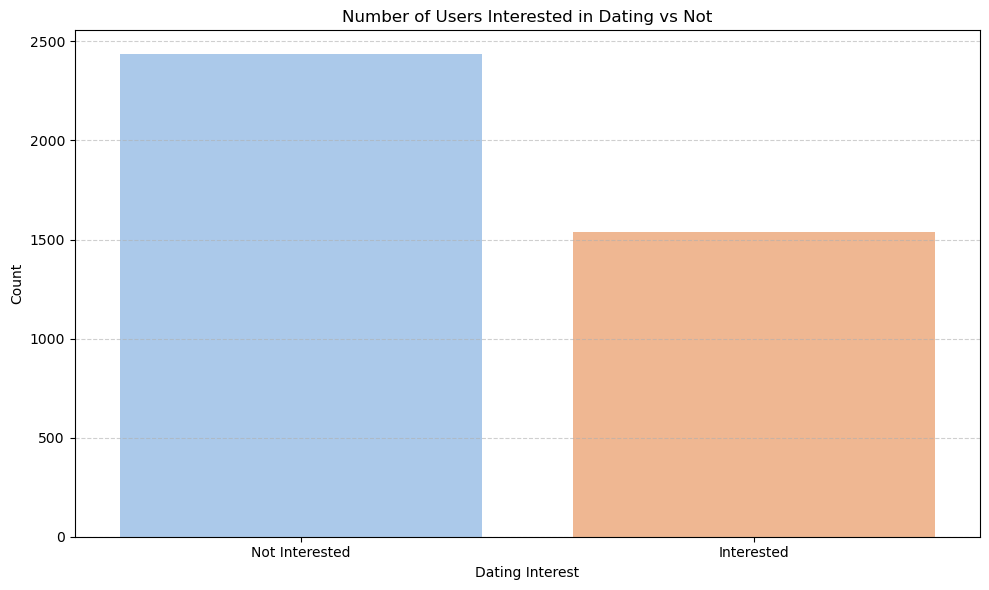

In [186]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='flirtInterests_date', hue='flirtInterests_date', palette='pastel', legend=False)

plt.xticks([0, 1], ['Not Interested', 'Interested'])
plt.title('Number of Users Interested in Dating vs Not')
plt.ylabel('Count')
plt.xlabel('Dating Interest')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Out of 3,972 users, 1,538 (38.7%) indicated that they are interested in dating, while 2,434 (61.3%) are not.

This shows that the majority of users in the dataset are not actively seeking a romantic relationship,  
which makes the behavioral comparison between the two groups even more interesting for further analysis.

### 2. Age Comparison

- Are dating-interested users older or younger on average?
- Any noticeable difference in age range or outliers?

In [187]:
def summary_stats(series):
    return f'''
        Mean: {round(series.mean(), 2)}
        Median: {series.median()}
        IQR: {series.quantile(0.75) - series.quantile(0.25)}
        '''

print("Interested in Dating:", summary_stats(dating_users['age']))
print("Not Interested in Dating:", summary_stats(non_dating_users['age']))

Interested in Dating: 
        Mean: 22.14
        Median: 22.0
        IQR: 3.0
        
Not Interested in Dating: 
        Mean: 21.91
        Median: 22.0
        IQR: 3.0
        


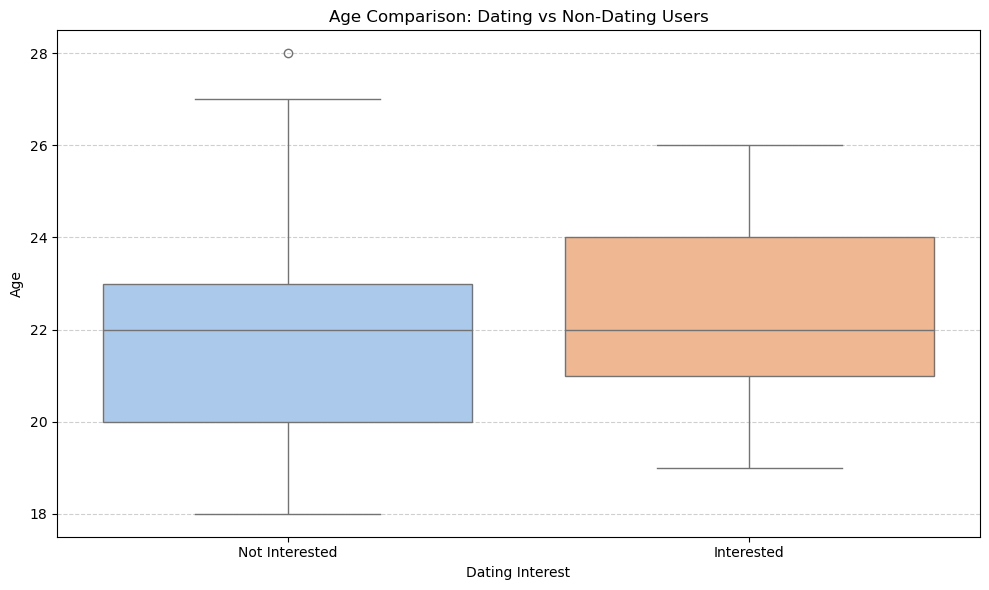

In [188]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='flirtInterests_date', y='age', data=df, hue='flirtInterests_date', palette='pastel', legend=False)

plt.xticks([0, 1], ['Not Interested', 'Interested'])
plt.title('Age Comparison: Dating vs Non-Dating Users')
plt.xlabel('Dating Interest')
plt.ylabel('Age')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### Age Distribution by Dating Interest

The box plot and summary statistics show that the age distribution is nearly identical for both groups:

| Group                   | Mean Age | Median Age | IQR |
|-------------------------|----------|-------------|-----|
| Interested in Dating    | 22.14     | 22.0        | 3.0 |
| Not Interested in Dating| 21.91     | 22.0        | 3.0 |

Both groups are concentrated between ages 20 and 25, with a few outliers extending beyond that range.  
The **median age** is the same (22), and the **IQR** is also equal, suggesting that **age is not a strong differentiator** between users who are interested in dating and those who are not.

### 3. Profile Completeness

Features: `counts_details`, `freetext`, `whazzup`

- Do dating-interested users complete more profile sections?
- Are they more likely to write a bio or status?

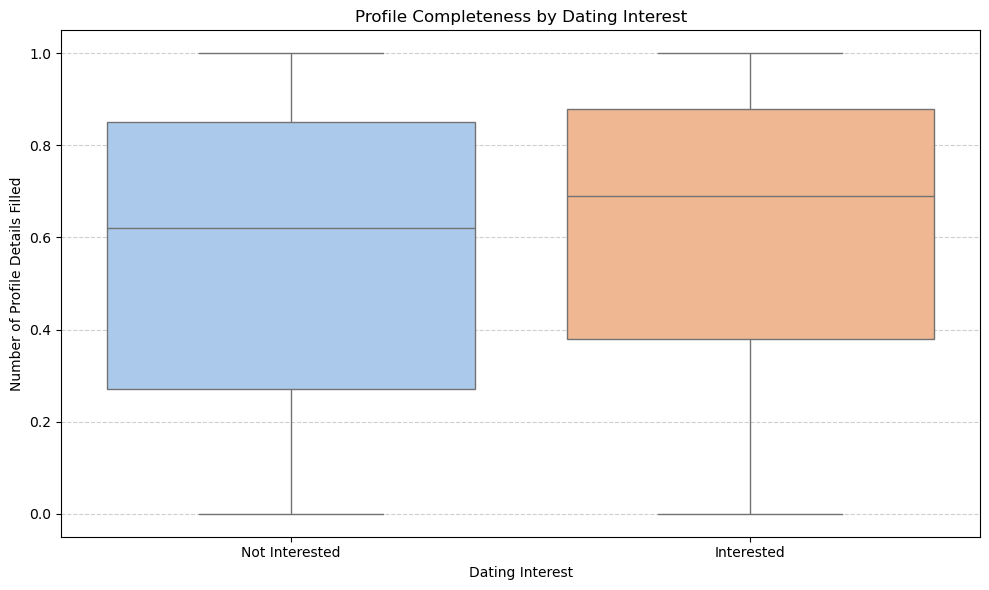

In [189]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='flirtInterests_date', y='counts_details', data=df, palette='pastel', hue='flirtInterests_date', legend=False)
plt.xticks([0, 1], ['Not Interested', 'Interested'])
plt.title('Profile Completeness by Dating Interest')
plt.xlabel('Dating Interest')
plt.ylabel('Number of Profile Details Filled')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

The box plot above shows that users who are **interested in dating** tend to fill slightly more profile sections on average compared to those who are not. However, the difference is small and distributions largely overlap.


In [190]:
def count_non_empty(series):
    return (series.notna()) & (series.str.strip() != '')

# count filled for dating group
dating_filled = count_non_empty(dating_users['freetext']).sum() + count_non_empty(dating_users['whazzup']).sum()
dating_total = len(dating_users) * 2  # 2 fields per user
dating_not_filled = dating_total - dating_filled

# count filled for non-dating group
non_dating_filled = count_non_empty(non_dating_users['freetext']).sum() + count_non_empty(non_dating_users['whazzup']).sum()
non_dating_total = len(non_dating_users) * 2
non_dating_not_filled = non_dating_total - non_dating_filled

summary = pd.DataFrame({
    'Filled': [dating_filled, non_dating_filled],
    'Not Filled': [dating_not_filled, non_dating_not_filled]
}, index=['Interested in Dating', 'Not Interested'])
summary['Filled, (%)'] = round(summary['Filled'] / (summary['Filled'] + summary['Not Filled']) * 100, 1) 
summary['Not Filled, (%)'] = round(summary['Not Filled'] / (summary['Filled'] + summary['Not Filled']) * 100, 1)

display(summary)

,Filled,Not Filled,"Filled, (%)","Not Filled, (%)"
Interested in Dating,1025,2051,33.3,66.7
Not Interested,1480,3388,30.4,69.6


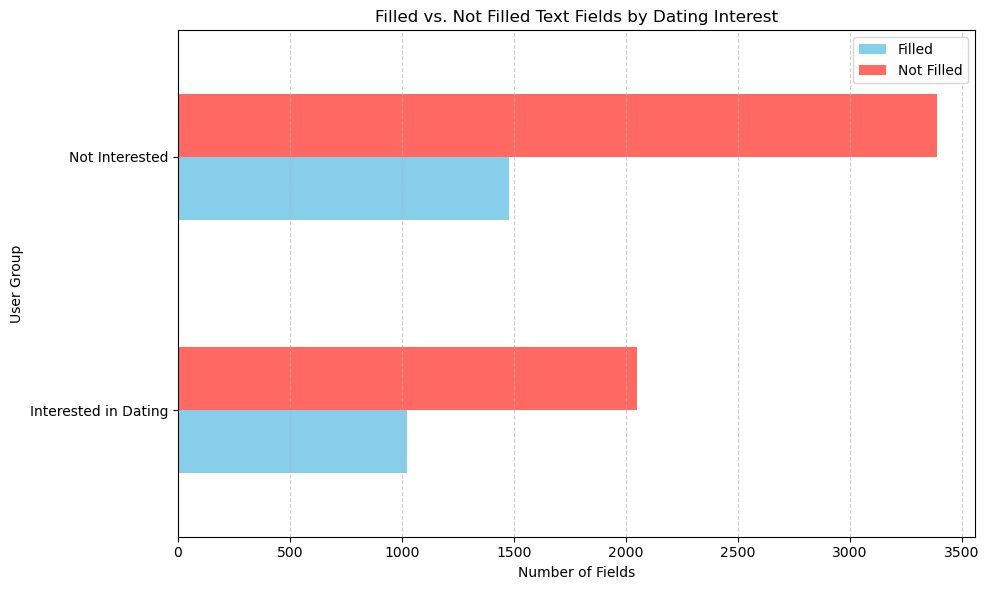

In [ ]:
summary[['Filled', 'Not Filled']].plot(kind='barh', stacked=False, color=['skyblue', '#FF6961'], figsize=(10, 6))

plt.title('Filled vs. Not Filled Text Fields by Dating Interest')
plt.xlabel('Number of Fields')
plt.ylabel('User Group')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

While the difference isn't dramatic, users who are interested in dating appear to invest a bit more effort into completing their profile.

### 4. Profile Engagement Metrics
Features: `counts_profileVisits`, `counts_kisses`, `counts_fans`, `counts_pictures`

- Who receives more visits/kisses/fans on average?
- Do dating-interested users post more pictures?

In [192]:
# calculate mean values grouped by dating interest
engagement_features = ['counts_profileVisits', 'counts_kisses', 'counts_fans', 'counts_pictures']
grouped_means = df.groupby('flirtInterests_date')[engagement_features].mean().T

grouped_means.columns = ['Not Interested', 'Interested']
display(grouped_means)

,Not Interested,Interested
counts_profileVisits,3455.315119,4110.331599
counts_kisses,147.024651,172.524707
counts_fans,2.338127,2.356307
counts_pictures,4.744043,4.853706


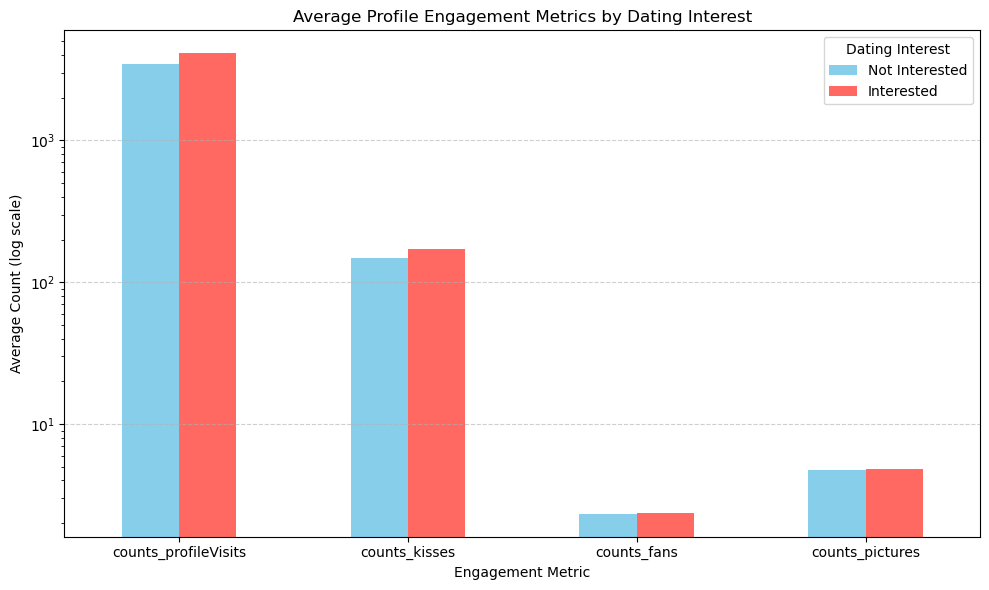

In [195]:
grouped_means.plot(kind='bar', figsize=(10, 6), color=['skyblue', '#FF6961'])
plt.title('Average Profile Engagement Metrics by Dating Interest')
plt.ylabel('Average Count (log scale)')
plt.xlabel('Engagement Metric')
plt.yscale('log')  # counts_fans and counts_pictures are too small compared to the other values
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='Dating Interest')
plt.tight_layout()
plt.show()

On average, users who are interested in dating receive slightly more profile visits and kisses.  
The difference is visible but not dramatic, and the use of a log scale highlights the wide range in values.

This suggests that dating-interested users may be slightly more engaged or visible on the platform.

## Methodology Thoughts

Before wrapping up my reflection on the EDA, I want to briefly address some thoughts on the dataset's methodology.

I believe this dataset is **inherently biased**, and that’s important to acknowledge when interpreting the results.

To start, the sample is limited to **female users** who are either heterosexual or bisexual, and all are within a narrow age range — **18 to 28 years old**.  
That means our EDA only reflects behaviors within this specific group and can't be generalized to users of other genders, orientations, or age brackets.

Additionally, the profiles were gathered based on **recommendations made to two male accounts**, which introduces further bias:
- These accounts were configured as open to chats, friendships, and dating.
- The users shown by the app were algorithmically selected, possibly influenced by location, activity, or engagement signals.
- As a result, we may be seeing only the most "visible" or algorithmically favored users.

This context is important when interpreting patterns like profile engagement or text field completion.  
Some behaviors might reflect not only user intent, but also how the app surfaces and promotes certain types of profiles.

While the dataset is still valuable for understanding trends within this narrow group, it should be treated as **non-representative of the broader dating app population**.

## Reflections

This analysis focuses on two groups of users in the dataset:

- Users who are **interested in dating** (`flirtInterests_date = True`)
- Users who are **not interested in dating** (`flirtInterests_date = False`)

Out of 3,972 users, 1,538 (38.7%) indicated interest in dating, while 2,434 (61.3%) did not.
This suggests that most users in the dataset are not actively seeking romantic connections, making it especially relevant to compare how these two groups behave differently.

### Age Distribution

| Group                   | Mean Age | Median Age | IQR |
|-------------------------|----------|------------|-----|
| Interested in Dating    | 22.14     | 22.0       | 3.0 |
| Not Interested in Dating| 21.91     | 22.0       | 3.0 |

The age distributions are nearly identical. Both groups cluster between ages 20 and 25, with the same median and IQR. Age, therefore, is **not a meaningful differentiator** between groups.

### Profile Completeness

Box plots show that users interested in dating tend to fill out slightly more profile sections, and are a bit more likely to complete optional text fields such as `freetext` and `whazzup`.  
The difference is modest but consistent, suggesting these users may put more effort into self-presentation.

### Engagement Metrics

Users interested in dating receive more profile visits and kisses on average. Although the differences are not large, they are noticeable. On a log scale, this gap becomes clearer, especially in high-variance metrics like profile visits.

### Final Thoughts

Overall, users who are interested in dating appear slightly more intentional and active:  they fill out more of their profile, include more personal text, and receive more engagement.  
While these differences aren't dramatic, they point toward a pattern of **higher platform engagement** and **greater visibility** among users who signal dating interest.